In [1]:
#Imports
import sys; sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
import pickle
from src import *
from fast_histogram import histogram1d
from scipy.linalg import orthogonal_procrustes
from copy import deepcopy

In [2]:
#Matrix Parameters
n = 128
rank = 60
res = 1e-12
normalization = 1e-12
rowSpaces = ['coherent', 'incoherent']
matrices = {}
Vs = {}
ks = [5, 30, 45, 60, 75]

figSize = (10,6)

for rowSpace in rowSpaces:
    U, sigma, V = getMatrix(n, rank, res, rowSpace, returnSVD = True, steepness=.5)
    A = U @ sigma @ V.T
    matrices[rowSpace] = A
    Vs[rowSpace] = V
    print(coherence(V, 10))

0.8048348815086018
0.4073386960753632


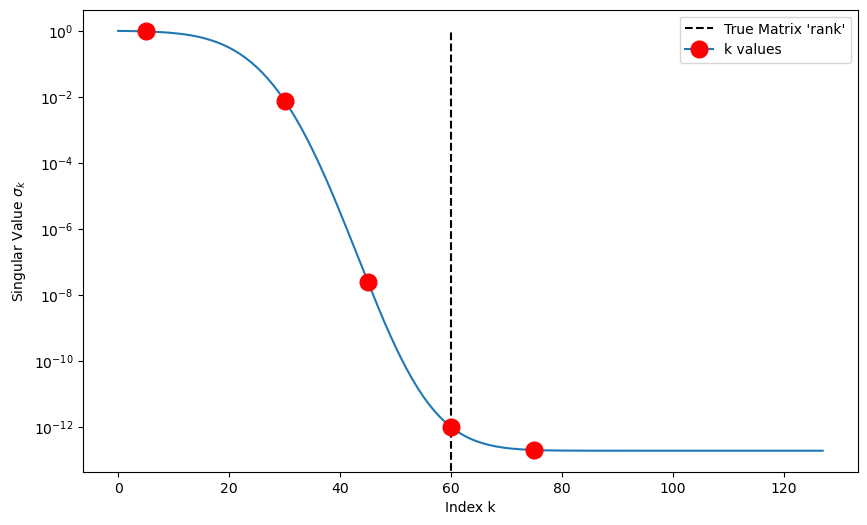

In [3]:
#Plot k values on singular spectrum
fig, ax = plt.subplots(figsize=figSize)
plt.semilogy(range(n), np.diag(sigma)[:n])
plt.vlines(x=rank, ymin = 0, ymax = 1, color = 'black', linestyles='--', 
           label = "True Matrix 'rank'")
for k in ks:
    if k == ks[0]:
        plt.plot([k], np.diag(sigma)[k], color = '#1f77b4',marker='o', markersize=12, 
                 markeredgecolor="red", markerfacecolor="red", label = 
                 'k values')
    else:
        plt.plot([k], np.diag(sigma)[k], marker='o', markersize=12, 
                 markeredgecolor="red", markerfacecolor="red")

plt.xlabel('Index k')
plt.ylabel(r'Singular Value $\sigma_k$')
plt.legend()

In [4]:
#Algorithm Parameters
sketchType = 'Gaussian'
trialNumber = 1000
oversampling = [0,2,4]
indices = range(n)

In [5]:
#Get RGKS column selection distributions
data = {}
errorData = {}
projectorData = {}

for k in ks:

    rowSpaceData = {}
    rowSpaceErrorData = {}
    rowSpaceProjectorData = {}

    for rowSpace in rowSpaces:

        A = matrices[rowSpace]

        pData = {}
        pErrorData = {}
        pProjectorData = {}

        for p in oversampling:

            print('k = ' + str(k) + ', ' + rowSpace + ', Oversampling: ' + str(p))

            rgksIndices = []
            trialErrors = []
            projectors = []
            
            for i in range(trialNumber):
                Ahat, rgksPi, rgksV = randomGKS(A, k, p, sketchType, getDist=True, getV=True)
                rgksIndices = np.append(rgksIndices, rgksPi)
                trialErrors.append(np.linalg.norm(Ahat-A, ord = 2)/normalization)
                projectors.append(rgksV)

            #Package results for graphing
            rgksKeys, rgksCounts = np.unique(rgksIndices, return_counts=True)
            rgksDict = dict(zip(rgksKeys, rgksCounts))

            rgksData = []

            for j in indices:

                if j in rgksDict: rgksData.append(rgksDict[j]) 
                else: rgksData.append(0)
            
            pData[p] = np.array(rgksData)
            pErrorData[p] = np.array(trialErrors)
            pProjectorData[p] = np.array(projectors)
        
        rowSpaceData[rowSpace] = pData
        rowSpaceErrorData[rowSpace] = pErrorData
        rowSpaceProjectorData[rowSpace] = pProjectorData

    data[k] = rowSpaceData
    errorData[k] = rowSpaceErrorData
    projectorData[k] = rowSpaceProjectorData

k = 5, coherent, Oversampling: 0
k = 5, coherent, Oversampling: 2
k = 5, coherent, Oversampling: 4
k = 5, incoherent, Oversampling: 0
k = 5, incoherent, Oversampling: 2
k = 5, incoherent, Oversampling: 4
k = 30, coherent, Oversampling: 0
k = 30, coherent, Oversampling: 2
k = 30, coherent, Oversampling: 4
k = 30, incoherent, Oversampling: 0
k = 30, incoherent, Oversampling: 2
k = 30, incoherent, Oversampling: 4
k = 45, coherent, Oversampling: 0
k = 45, coherent, Oversampling: 2
k = 45, coherent, Oversampling: 4
k = 45, incoherent, Oversampling: 0
k = 45, incoherent, Oversampling: 2
k = 45, incoherent, Oversampling: 4
k = 60, coherent, Oversampling: 0
k = 60, coherent, Oversampling: 2
k = 60, coherent, Oversampling: 4
k = 60, incoherent, Oversampling: 0
k = 60, incoherent, Oversampling: 2
k = 60, incoherent, Oversampling: 4
k = 75, coherent, Oversampling: 0
k = 75, coherent, Oversampling: 2
k = 75, coherent, Oversampling: 4
k = 75, incoherent, Oversampling: 0
k = 75, incoherent, Oversamp

In [6]:
#Get GKS column selection distribution
gksData = {}
gksError = {}

for k in ks:

    gksRowSpaceData = {}
    gksErrorData = {}

    for rowSpace in rowSpaces:

        A = matrices[rowSpace]

        gksResults = np.zeros(n)

        gksIndices = []
        AhatGKS, gksPi = GKS(A, k, getDist = True)
        gksErrorData[rowSpace] = np.linalg.norm(AhatGKS-A, ord = 2)/normalization

        for i in gksPi:
            gksResults[i] = trialNumber
        gksRowSpaceData[rowSpace] = np.array(gksResults)
    
    gksData[k] = gksRowSpaceData
    gksError[k] = gksErrorData

In [7]:
#Get right singular leverage scores
leverageScores = {}

for k in ks:

    rowSpaceLeverageScores = {}

    for rowSpace in rowSpaces:
        V = Vs[rowSpace]
        rowSpaceLeverageScores[rowSpace] = np.array(matrixLeverageScores(V[:,:k], 'row'))
    
    leverageScores[k] = rowSpaceLeverageScores

In [8]:
#Save Data
with open('leverageScores.pkl', 'wb') as f:
    pickle.dump(leverageScores, f)

with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

with open('errorData.pkl', 'wb') as f:
    pickle.dump(errorData, f)

with open('projectorData.pkl', 'wb') as f:
    pickle.dump(projectorData, f)

with open('gksData.pkl', 'wb') as f:
    pickle.dump(gksData, f)

with open('gksError.pkl', 'wb') as f:
    pickle.dump(gksError, f)

In [9]:
#Load Data
with open('leverageScores.pkl', 'rb') as f:
    leverageScores = pickle.load(f)

with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

with open('errorData.pkl', 'rb') as f:
    errorData = pickle.load(f)

with open('projectorData.pkl', 'rb') as f:
    projectorData = pickle.load(f)

with open('gksData.pkl', 'rb') as f:
    gksData = pickle.load(f)

with open('gksError.pkl', 'rb') as f:
    gksError = pickle.load(f)


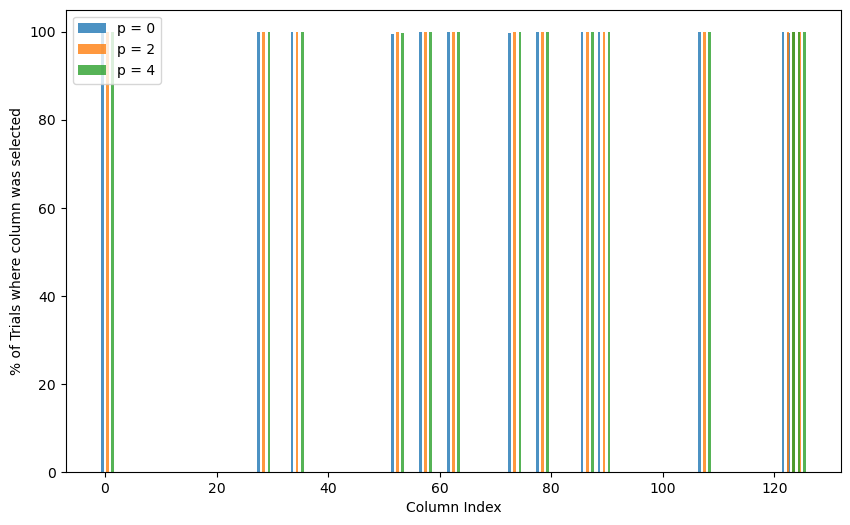

In [10]:
#Plotting index distribution for different oversampling
fig, ax = plt.subplots(figsize=figSize)
opacity = 0.8

displayType = 'pSort'
pSort = 2
displayNumber = 14

rowSpace = 'incoherent'
k = 60

if displayType == 'interval':
    displayInterval = 3
    bar_width = displayInterval*.15
    viewIndices = np.array(indices[:][::displayInterval])

elif displayType == 'pSort':
    bar_width = n/displayNumber *.05
    viewIndices = np.argsort(data[k][rowSpace][pSort])[::-1][:displayNumber]

for p in oversampling:
    plt.bar((viewIndices + (p-1)*bar_width), 
                data[k][rowSpace][p][viewIndices]*100/trialNumber, bar_width,
        alpha=opacity,
        label='p = ' + str(p))

plt.xlabel('Column Index')
plt.ylabel('% of Trials where column was selected')
plt.legend()

[  0  12  28  34  36  52  57  62  73  78  86  89 107 108 122 123 124]
[  0   2  28  34  36  52  57  62  70  73  78  86  89 107 122 123 124]
[  0   2  12  28  34  52  57  62  70  73  78  86  89 107 122 123 124]


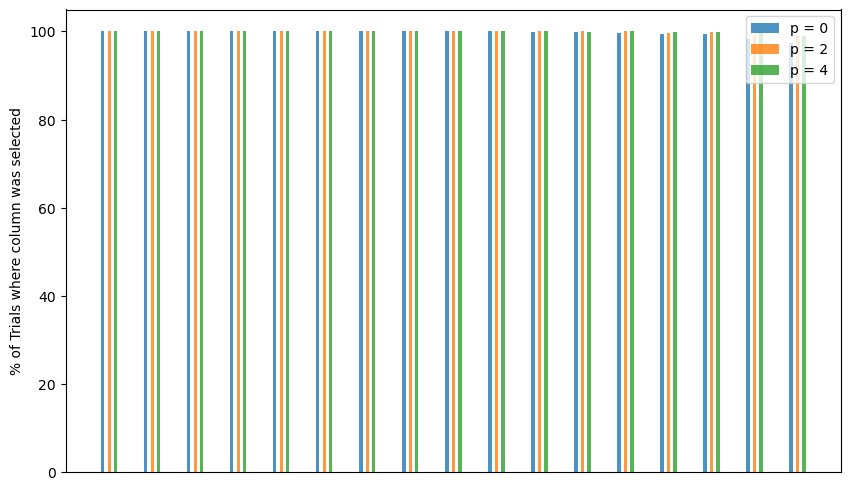

In [11]:
#Top columns for different oversampling
fig, ax = plt.subplots(figsize=figSize)
opacity = 0.8

displayType = 'pSort'
pSort = 0
displayNumber = 17

rowSpace = 'incoherent'
k = 60

if displayType == 'interval':
    displayInterval = 1
    bar_width = displayInterval*.15
    viewIndices = np.array(indices[:][::displayInterval])

elif displayType == 'pSort':
    bar_width = n/displayNumber *.01
    viewIndices = np.argsort(data[k][rowSpace][pSort])[::-1][:displayNumber]

for p in oversampling:
    plt.bar(np.array(range(len(viewIndices))) + 1 + (p-2)*bar_width, 
        data[k][rowSpace][p][viewIndices]*100/trialNumber, bar_width, alpha=opacity,
        label='p = ' + str(p))
    
plt.ylabel('% of Trials where column was selected')
plt.xticks([])
plt.legend() 

for i in oversampling:
    print(np.sort(np.argsort(data[k][rowSpace][i])[::-1][:displayNumber]))

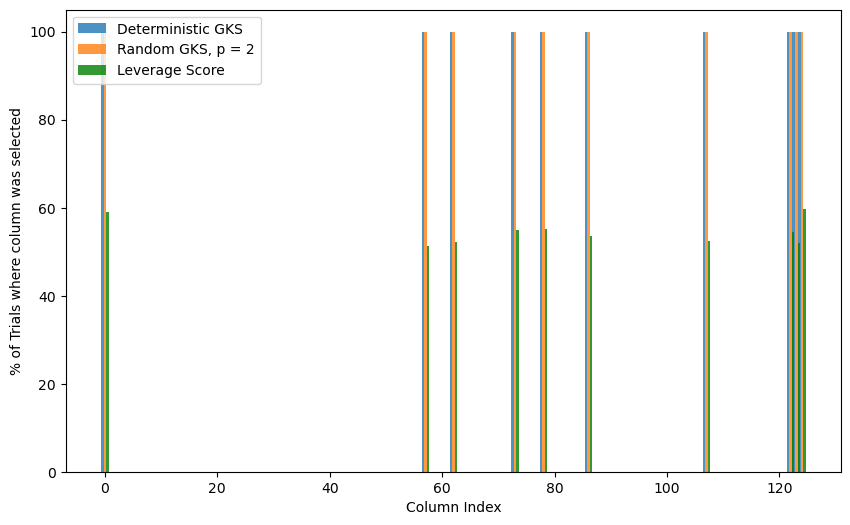

In [12]:
#Plotting index distribution for different quantities
rowSpace = 'incoherent'
k = 60
p = 2

fig, ax = plt.subplots(figsize=figSize)
opacity = 0.8

r = np.sum(leverageScores[k][rowSpace])
levScoreCounts = np.array(leverageScores[k][rowSpace]*trialNumber*k/r)

#Display
displayType = 'sortRGKS'
displayInterval = 3
displayNumber = 10

if displayType == 'interval':
    barWidth = displayInterval*.15
    viewIndices = indices[::displayInterval]

elif displayType == 'sortRGKS':
    barWidth = displayInterval*.15
    viewIndices = np.argsort(data[k][rowSpace][p])[::-1][:displayNumber]

elif displayType == 'sortGKS':
    barWidth = displayInterval*.15
    viewIndices = np.argsort(gksData[k][rowSpace])[::-1][:displayNumber]

elif displayType == 'sortLS':
    barWidth = displayInterval*.15
    viewIndices = np.argsort(levScoreCounts)[::-1][:displayNumber]

#Graphing
plt.bar((np.array(viewIndices) - barWidth), gksData[k][rowSpace][viewIndices]*100/trialNumber, barWidth,
alpha=opacity, label='Deterministic GKS')

plt.bar(viewIndices, data[k][rowSpace][p][viewIndices]*100/trialNumber, barWidth,
alpha=opacity, label='Random GKS, p = ' + str(p))

plt.bar((np.array(viewIndices) + barWidth), levScoreCounts[viewIndices]*100/trialNumber, barWidth,
alpha=opacity, color='green', label='Leverage Score')

plt.xlabel('Column Index')
plt.ylabel('% of Trials where column was selected')
plt.legend()

[  0 102  89  20  83  82  81  80  24  78  26  75  72  70  28  29  65  62
  34  35]


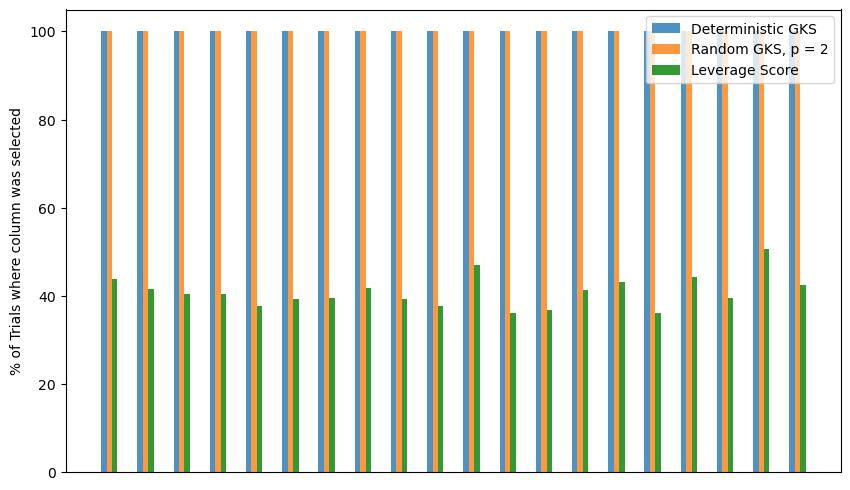

In [13]:
#Plotting index distribution for different quantities (sorted)
rowSpace = 'incoherent'
k = 45
p = 2

fig, ax = plt.subplots(figsize=figSize)
opacity = 0.8

r = np.sum(leverageScores[k][rowSpace])
levScoreCounts = np.array(leverageScores[k][rowSpace]*trialNumber*k/r)

#Display
displayType = 'sortRGKS'
displayInterval = 3
displayNumber = 20

if displayType == 'interval':
    barWidth = displayInterval*.15
    viewIndices = indices[::displayInterval]

elif displayType == 'sortRGKS':
    barWidth = displayInterval*.05
    viewIndices = np.argsort(data[k][rowSpace][p])[::-1][:displayNumber]
    print(viewIndices)

elif displayType == 'sortGKS':
    barWidth = displayInterval*.05
    viewIndices = np.argsort(gksData[k][rowSpace])[::-1][:displayNumber]

elif displayType == 'sortLS':
    barWidth = displayInterval*.05
    viewIndices = np.argsort(levScoreCounts)[::-1][:displayNumber]

#Graphing
plt.bar((np.array(range(len(viewIndices))) - barWidth), gksData[k][rowSpace][viewIndices]*100/trialNumber, barWidth,
alpha=opacity, label='Deterministic GKS')

plt.bar(range(len(viewIndices)), data[k][rowSpace][p][viewIndices]*100/trialNumber, barWidth,
alpha=opacity, label='Random GKS, p = ' + str(p))

plt.bar((np.array(range(len(viewIndices))) + barWidth), levScoreCounts[viewIndices]*100/trialNumber, barWidth,
alpha=opacity, color='green', label='Leverage Score')

#plt.xlabel('Column Index')
plt.xticks([])
plt.ylabel('% of Trials where column was selected')
plt.legend()

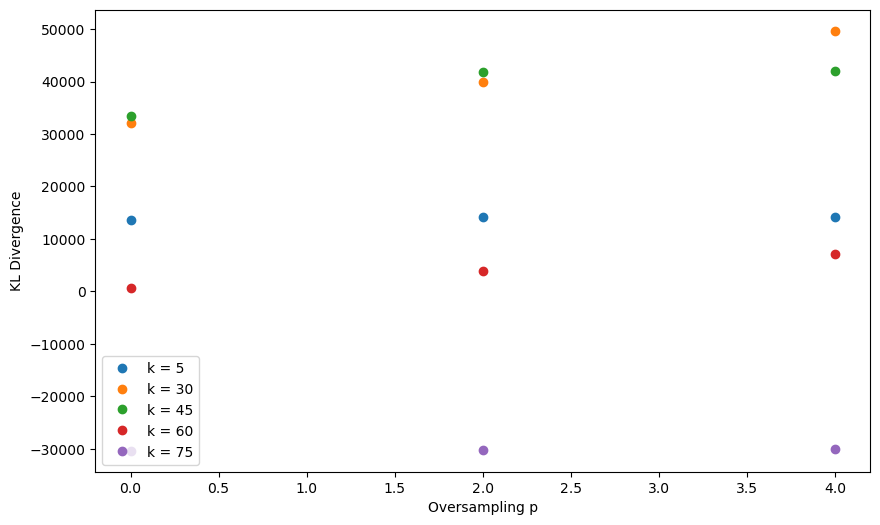

In [14]:
#KL Divergence
rowSpace = 'incoherent'

fig, ax = plt.subplots(figsize=figSize)

for k in ks:

    levScoreCounts = np.array(leverageScores[k][rowSpace]*trialNumber*k/r)

    klDivergences = []
    for p in oversampling:

        p = dict(zip(indices, data[k][rowSpace][p]))
        q = dict(zip(indices, levScoreCounts))

        klDivergences.append(klDivergence(indices,p,q))

    plt.plot(oversampling, klDivergences, 'o', label = 'k = ' + str(k))
    
plt.xlabel('Oversampling p')
plt.ylabel('KL Divergence')
plt.legend()

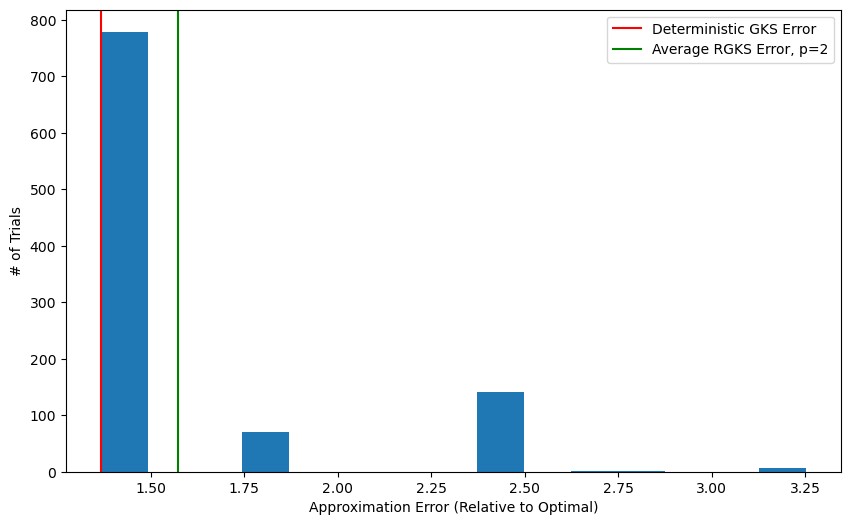

In [15]:
#Approximation Error (Coherent)
p = 2
rowSpace = 'coherent'
k = 60
errors = errorData[k][rowSpace][p]

fig, ax = plt.subplots(figsize=figSize)
plt.hist(errors, bins = 15)
plt.axvline(x = gksError[k][rowSpace], linestyle = '-', label = 'Deterministic GKS Error', color = 'red')
plt.axvline(x = np.average(errors), linestyle = '-', label = 'Average RGKS Error, p=' + str(p), color = 'green')

plt.xlabel('Approximation Error (Relative to Optimal)')
plt.ylabel('# of Trials')
plt.legend()

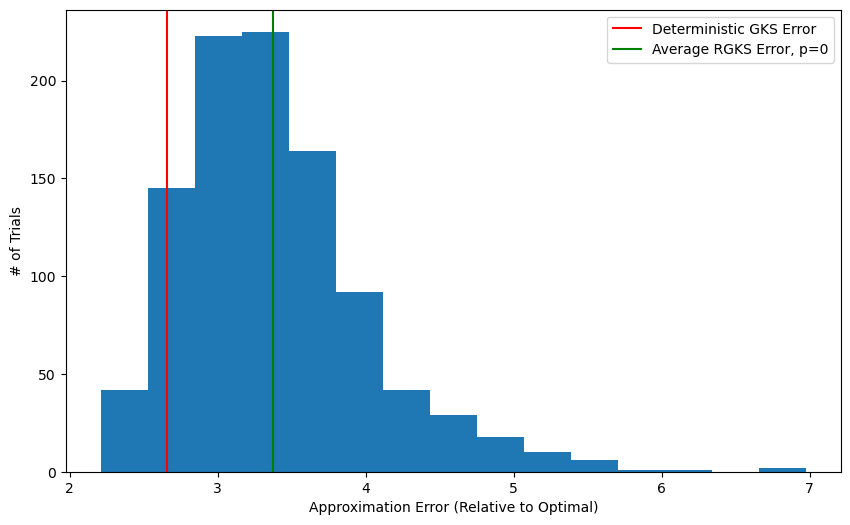

In [16]:
#Approximation Error (Incoherent)
p = 0
rowSpace = 'incoherent'
k=60

errors = errorData[k][rowSpace][p]

fig, ax = plt.subplots(figsize=figSize)
plt.hist(errors, bins = 15)
plt.axvline(x = gksError[k][rowSpace], linestyle = '-', label = 'Deterministic GKS Error', color = 'red')
plt.axvline(x = np.average(errors), linestyle = '-', label = 'Average RGKS Error, p=' + str(p), color = 'green')

plt.xlabel('Approximation Error (Relative to Optimal)')
plt.ylabel('# of Trials')
plt.legend()

In [17]:
#Compute different Types of projectors
def averageProjector(Vhats, averageType, procustus = False):

    newVhats = []

    #Perform Orthogonal Procustus on matrices
    if procustus:

        targetVhat = Vhats[0]

        for Vhat in Vhats:
            Qi, _ = orthogonal_procrustes(Vhat, targetVhat)
            newVhats.append(Vhat@Qi)
    else:
        newVhats = deepcopy(Vhats)

    #Average by sum or project first
    if averageType == 'sum first':
        avgVhat = np.average(newVhats, axis=0)
        return avgVhat@avgVhat.T
    
    elif averageType == 'project first':
        
        result = np.zeros((len(newVhats[0]), len(newVhats[0])))

        for Vhat in newVhats:
            result += (Vhat@Vhat.T)/len(Vhats)
        return result

In [1]:
#Projector Error Heatmap (All)
fig, ax = plt.subplots(1,3,figsize=figSize)

rowSpace = 'coherent'
averageType = 'project first'
procustus = False
p = 2
k = 60

Vhats = projectorData[k][rowSpace][p]
V = Vs[rowSpace][:,:k]
avgProjector = averageProjector(Vhats, averageType, procustus)

#True Projector
fig.colorbar(ax[0].imshow(V@V.T),ax=ax[0], shrink = .35)
ax[0].set_title(r'True Projector $VV^\top$')

#Average RGKS projector
fig.colorbar(ax[1].imshow(avgProjector),ax=ax[1], shrink = .35)
ax[1].set_title(r'Avg RGKS Projector')

#Difference
fig.colorbar(ax[2].imshow(np.abs(V@V.T - avgProjector)), ax = ax[2], shrink = .35)
ax[2].set_title(r'Difference')

NameError: name 'plt' is not defined

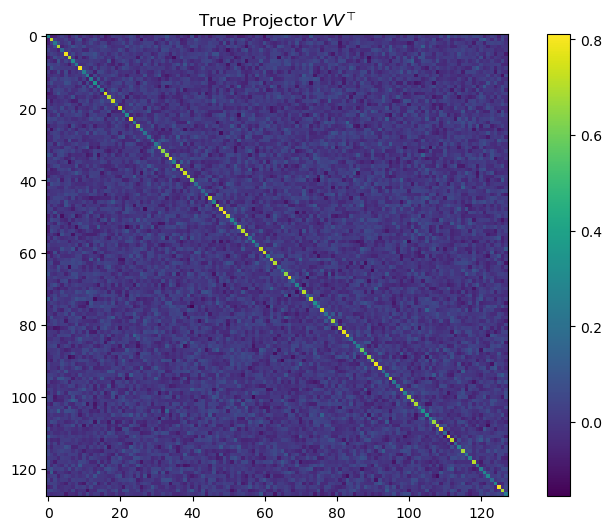

In [19]:
#Projector Error Heatmap (Individual)
fig, ax = plt.subplots(figsize=figSize)

rowSpace = 'coherent'
averageType = 'project first'
procustus = False
p = 2
k = 60

Vhats = projectorData[k][rowSpace][p]
V = Vs[rowSpace][:,:k]
avgProjector = averageProjector(Vhats, averageType, procustus)

plot = 'True'

#True Projector
if plot == 'True':
    plt.colorbar(ax.imshow(V@V.T),ax=ax)
    ax.set_title(r'True Projector $VV^\top$')

#Average RGKS projector
elif plot == 'RGKS':
    plt.colorbar(ax.imshow(avgProjector),ax=ax)
    ax.set_title(r'Avg RGKS Projector')

#Difference
elif plot == 'Difference':
    plt.colorbar(ax.imshow(np.abs(V@V.T - avgProjector)), ax = ax)
    ax.set_title(r'Difference')

<BarContainer object of 100 artists>

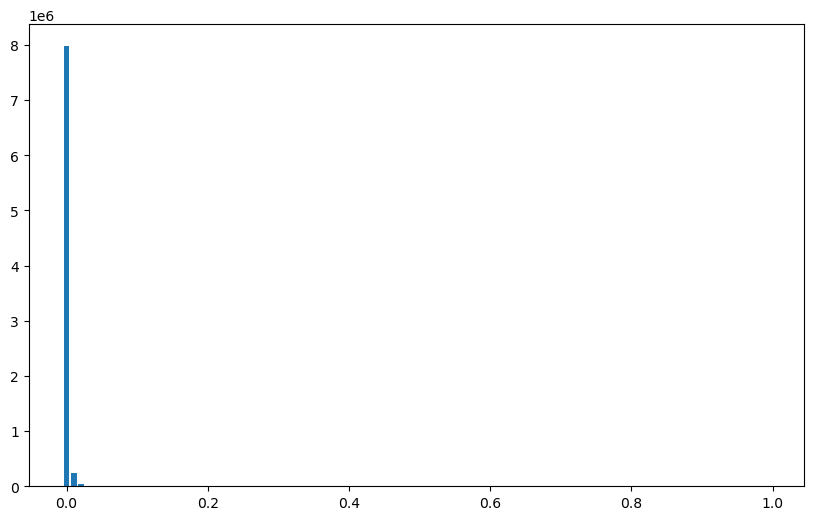

In [20]:
#Projector Error Distribution
rowSpace = 'incoherent'
p = 0
k = 45

Vhats = projectorData[k][rowSpace][p]
V = Vs[rowSpace][:,:k]
trueProjector = V@V.T
projectorErrors = []

for Vhat in Vhats:
    error = np.abs(trueProjector - Vhat@Vhat.T)
    projectorErrors += list(error[np.triu_indices(n)])

errorHist = histogram1d(projectorErrors, 100, (0,1))

fig, ax = plt.subplots(figsize=figSize)
plt.bar(np.arange(0,1,.01),errorHist, .008)
# ax.set_yscale('log')

In [21]:
#Spectral norm of projector difference
rowSpace = 'incoherent'
p = 2
spectralNorms = {}

#Get spectral norm difference for all k values
for k in ks:
    
    Vhats = projectorData[k][rowSpace][p]
    V = Vs[rowSpace][:,:k]
    trueProjector = V@V.T

    spectralK = []
    for Vhat in Vhats:
        spectralK.append(np.linalg.norm(V@V.T-Vhat@Vhat.T,2))
    spectralNorms[k] = spectralK

#Get average value for all k values
avgSpectralNorm = []
for k in ks:
    avgSpectralNorm.append(np.average(spectralNorms[k]))

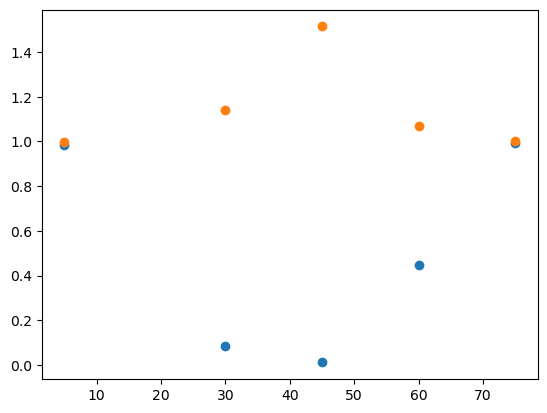

In [25]:
plt.plot(ks, avgSpectralNorm, 'o')

ders = []
singVals = np.diag(sigma)
for k in ks:
    ders.append((singVals[k+1] +singVals[k-1])/(2*singVals[k]))
plt.plot(ks, ders, 'o')